### Name, Student ID, Department of all your members.
111356001 資管碩一 陳靖汝 <br>
111356042 資管碩一 李振維 <br>

### A Title
Beth Dataset 之異常偵測
### Problem Definition
異常偵測的分析目標是識別和捕捉資料中的異常模式或行為。通過分析資料的統計特性、模式和趨勢，可以幫助我們發現偏離正常行為的離群資料點或事件。

具體而言，異常偵測的分析目標包括：
1. 發現異常資料點：識別資料集中與其他資料點明顯不同的離群值。這些異常資料點可能是由於錯誤、故障、詐騙、入侵或其他異常情況引起的。
2. 檢測異常模式：在資料中尋找不符合正常統計分佈或預期行為的異常模式或行為。例如，在網路流量中檢測到異常的連接請求量或不尋常的通訊模式。
3. 預測未來的異常事件：基於過去的資料和模式，試圖預測未來的異常事件。這有助於採取主動措施來預防或應對異常情況。

異常偵測的分析目標是識別和理解偏離正常行為的異常資料點或模式。這提供了監控、提前警報和處理異常事件的能力，有助於系統安全、發現潛在問題和異常情況，並採取適當的措施予以應對。

### Dataset
- Beth Dataset


### 系統架構
1. 資料分析
- Exploratory Data Analysis (EDA)

2. 資料前處理
- Data Cleaning：刪除對異常檢測任務沒有貢獻的任何不相關或冗餘的特徵。根據缺失數據的數量，通過估算缺失值或刪除具有缺失值的實例來處理缺失值。
- Feature Scaling：將數值特徵歸一化到相似的尺度，以確保它們在訓練期間具有同等重要性。常見的縮放技術包括 StandardScaler、MinMaxScaler
- Dimension Reduction (Feature Selection)：如果數據集具有高維特徵，可以考慮應用主成分分析（PCA）或t-SNE等降維技術來減少特徵空間，同時保留大部分相關信息。
- Preprocessing Pipeline：創建預處理管道以簡化數據預處理步驟。這通過在推理過程中對新數據應用相同的預處理步驟來確保一致性和可重複性。
模型建立

3. Auto-Encoder（自編碼器）
- VAE（變動自編碼器）
- one-class SVM（單類別支援向量機）
- Isolated Forest（孤立森林）

4. 模型評估
- confusion matrix


# BETH Dataset EDA, Preperation and Model Training

> BETH 資料集目前包含了 23 個 honeypot 上所收集的 8,004,918 個事件，持續運行了約五個不連續小時。為了進行基準測試和討論，選擇了初始子集的 log。這個子集進一步分成訓練、驗證和測試集，大致按照主機、生成的 log 數量和日誌記錄的活動進行 60/20/20 的分配，只有測試集包含了攻擊事件。除了是最現代化且規模最大的資訊安全資料集之一外，BETH還能夠在異構結構的現實世界數據上開發異常檢測算法

> 該資料集由兩種感測器 log 組成：內核級進程調用和網絡流量。初始的基準測試子集只包含進程日誌。每個進程調用包含 14 個原始特徵和2個手工製作的 label。


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # viz
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple
from sklearn import preprocessing

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn import metrics, linear_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive') # 授權存取 google drive 中的檔案

Mounted at /content/gdrive


# Initial Explore
## Load Data

In [ ]:
train_df = pd.read_csv('/content/gdrive/Shareddrives/網路安全/Dataset/labelled_training_data.csv') # 訓練資料
test_df = pd.read_csv('/content/gdrive/Shareddrives/網路安全/Dataset/labelled_testing_data.csv') # 測試資料
validation_df = pd.read_csv('/content/gdrive/Shareddrives/網路安全/Dataset/labelled_validation_data.csv') # 驗證資料

In [ ]:
print(len(train_df[train_df['sus']==0]))
print(len(train_df[train_df['sus']==1]))
print(len(test_df[test_df['sus']==0]))
print(len(test_df[test_df['sus']==1]))
print(len(validation_df[validation_df['sus']==0]))
print(len(validation_df[validation_df['sus']==1]))

761875
1269
17508
171459
188181
786


## Check all of the columns are the same across all three dataframes

- timestamp (float)：系統啟動時間
- processId：該日誌 process 生成時的整數標籤
- threadId：該日誌 thread 生成時的整數標籤
- parentProcessId：該日誌 process 的 parent process 生成時的整數標籤
- userId：產生此日誌的使用者的登入整數 ID
- mountNamespace：設置此進程日誌在其中工作的安裝限制
- processName：執行的字串命令
- hostName：主機伺服器的名稱
- eventId：生成此日誌的事件 ID
- eventName：生成此日誌的事件名稱
- stackAddresses：memory values relevant to the process
- argsNum：Length of args
- returnValue：Value returned from this event log (usually 0)
- args：List of arguments passed to this process
- sus：Binary label as a suspicious event (1 is suspicious, 0 is not)
- evil：Binary as a known malicious event (0 is benign, 1 is not)



In [ ]:
assert train_df.columns.all() == test_df.columns.all() == validation_df.columns.all()

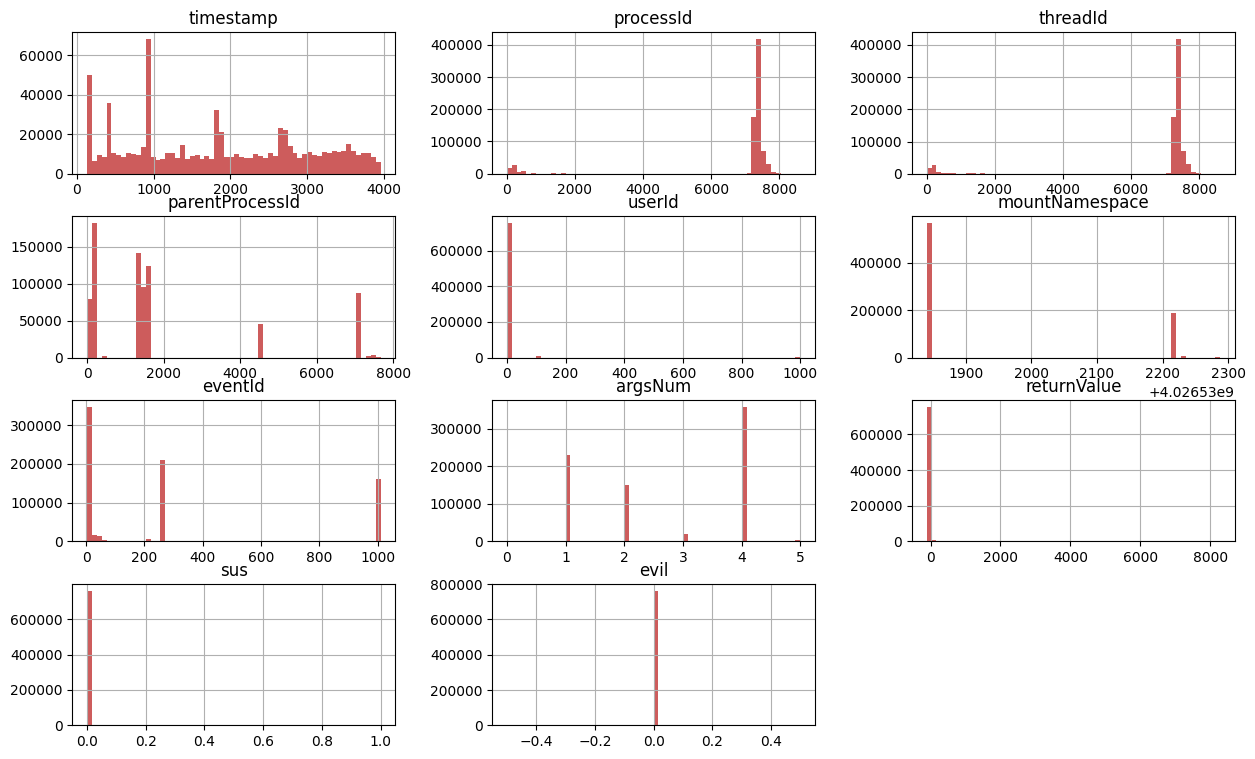

In [ ]:
#查看資料集的分佈
train_df.hist(bins=60, figsize=(15,9),color='IndianRed')
plt.show()

## Visual Inspection / Summary

1. train_df 可以從以下圖像化看出 training data 的 evil 以及 sus 值均為 0

In [ ]:
train_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


<Axes: title={'center': 'Label Frequency for evil label in Train Dataset'}>

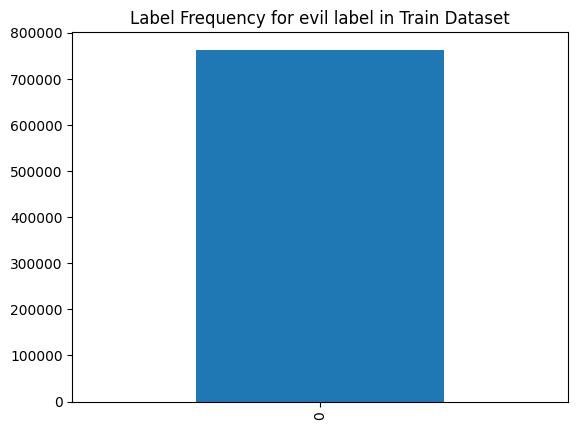

In [ ]:
train_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Train Dataset')

<Axes: title={'center': 'Label Frequency for sus label in Train Dataset'}>

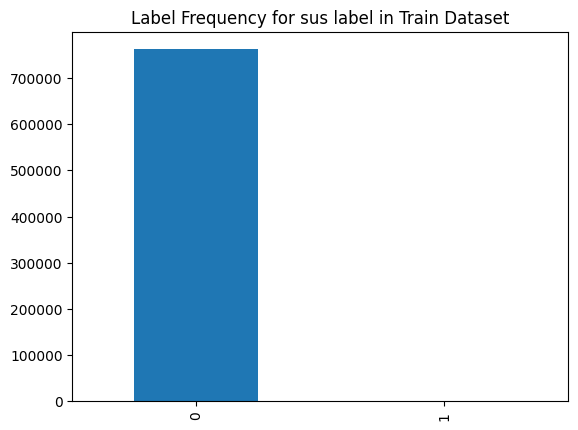

In [ ]:
train_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Train Dataset')

### `test` Dataset

<Axes: title={'center': 'Label Frequency for evil label in Test Dataset'}>

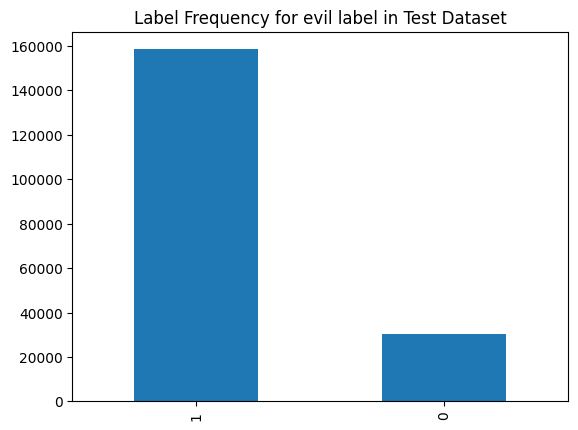

In [ ]:
test_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Test Dataset')

<Axes: title={'center': 'Label Frequency for sus label in Test Dataset'}>

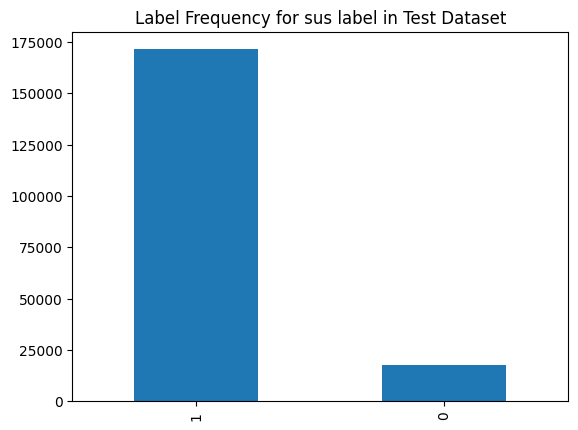

In [ ]:
test_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Test Dataset')

### `validation` dataset
1. validation_df 可以從以下圖像化看出 training data 的 evil 以及 sus 值均為 0

<Axes: title={'center': 'Label Frequency for evil label in Validation Dataset'}>

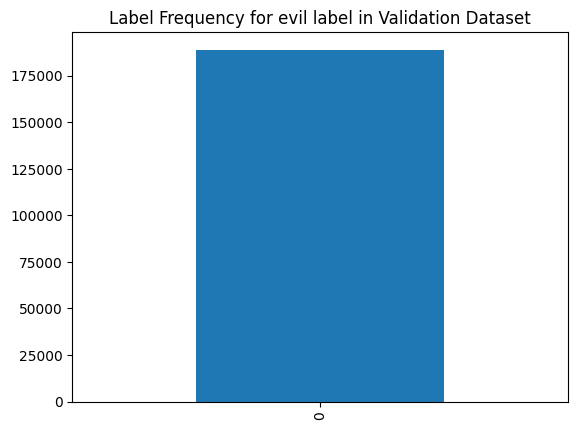

In [ ]:
validation_df.evil.value_counts().plot(kind='bar', title='Label Frequency for evil label in Validation Dataset')

<Axes: title={'center': 'Label Frequency for sus label in Validation Dataset'}>

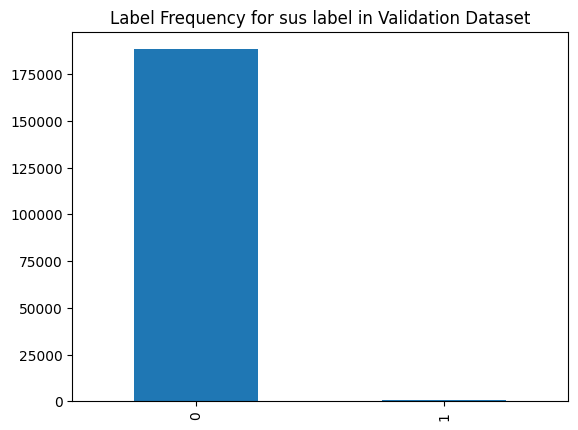

In [ ]:
validation_df.sus.value_counts().plot(kind='bar', title='Label Frequency for sus label in Validation Dataset')

## Are any events labelled both`sus` and `evil` in each dataset?

### `train` dataset

In [ ]:
train_df.groupby(['sus', 'evil'])[['timestamp']].count()

,,timestamp
sus,evil,
0,0,761875
1,0,1269


<Axes: xlabel='sus,evil'>

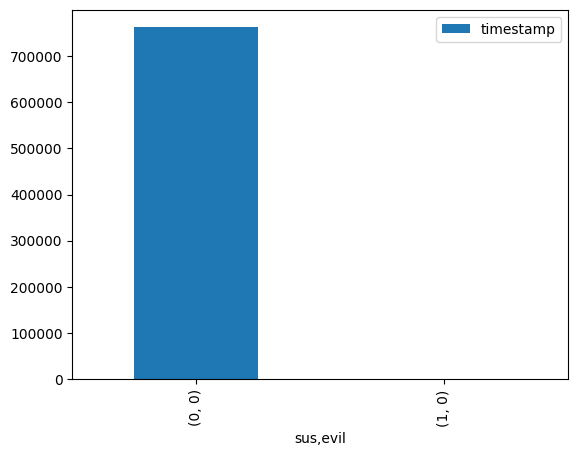

In [ ]:
train_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

### `test` dataset

In [ ]:
test_df.groupby(['sus', 'evil'])[['timestamp']].count()

timestamp
sus evil           
0   0         17508
1   0         13027
    1        158432

*Note: The snippet below is to double-check the results from the cell above.*

In [ ]:
test_df.loc[(test_df['sus'] == 1) & (test_df['evil'] == 1)].shape[0]

158432

<Axes: xlabel='sus,evil'>

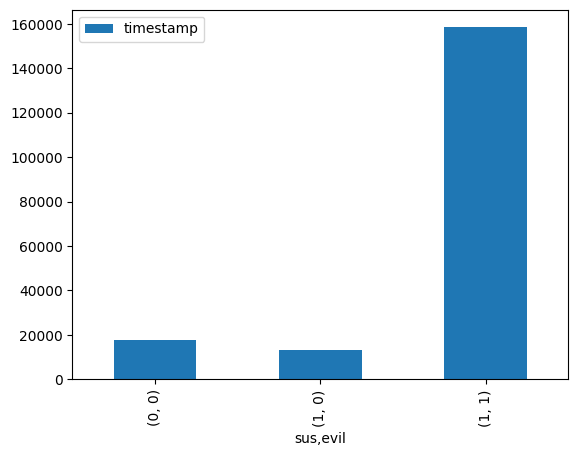

In [ ]:
test_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

### `validation` dataset

In [ ]:
validation_df.groupby(['sus', 'evil'])[['timestamp']].count()

,,timestamp
sus,evil,
0,0,188181
1,0,786


<Axes: xlabel='sus,evil'>

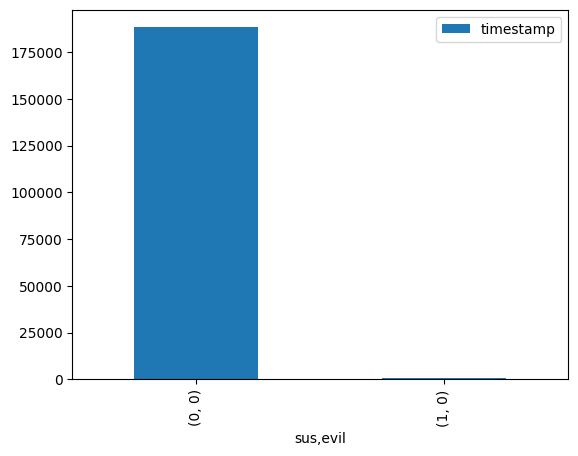

In [ ]:
validation_df.groupby(['sus', 'evil'])[['timestamp']].count().plot(kind='bar')

##### **結論**：
- 根據這些圖表的觀察，整體來看，存在資料不平衡的情況，在異常偵測中較為常見。

- 從論文中可以發現，資料不平衡的問題，為其中研究的核心目標，testing 的數據集是唯一包含標記為 evil 事件的數據集。

- 異常檢測方法很可能為此資料集的最佳選擇，例如使用自編碼器（Auto-Encoder）或單類支持向量機（One-Class SVM）。

## What is the correlation of features across each dataset?

In [ ]:
def dataset_to_corr_heatmap(dataframe, title, ax):
    corr = dataframe.corr()
    sns.heatmap(corr, ax = ax, annot=True, cmap="YlGnBu")
    ax.set_title(f'Correlation Plot for {title}')

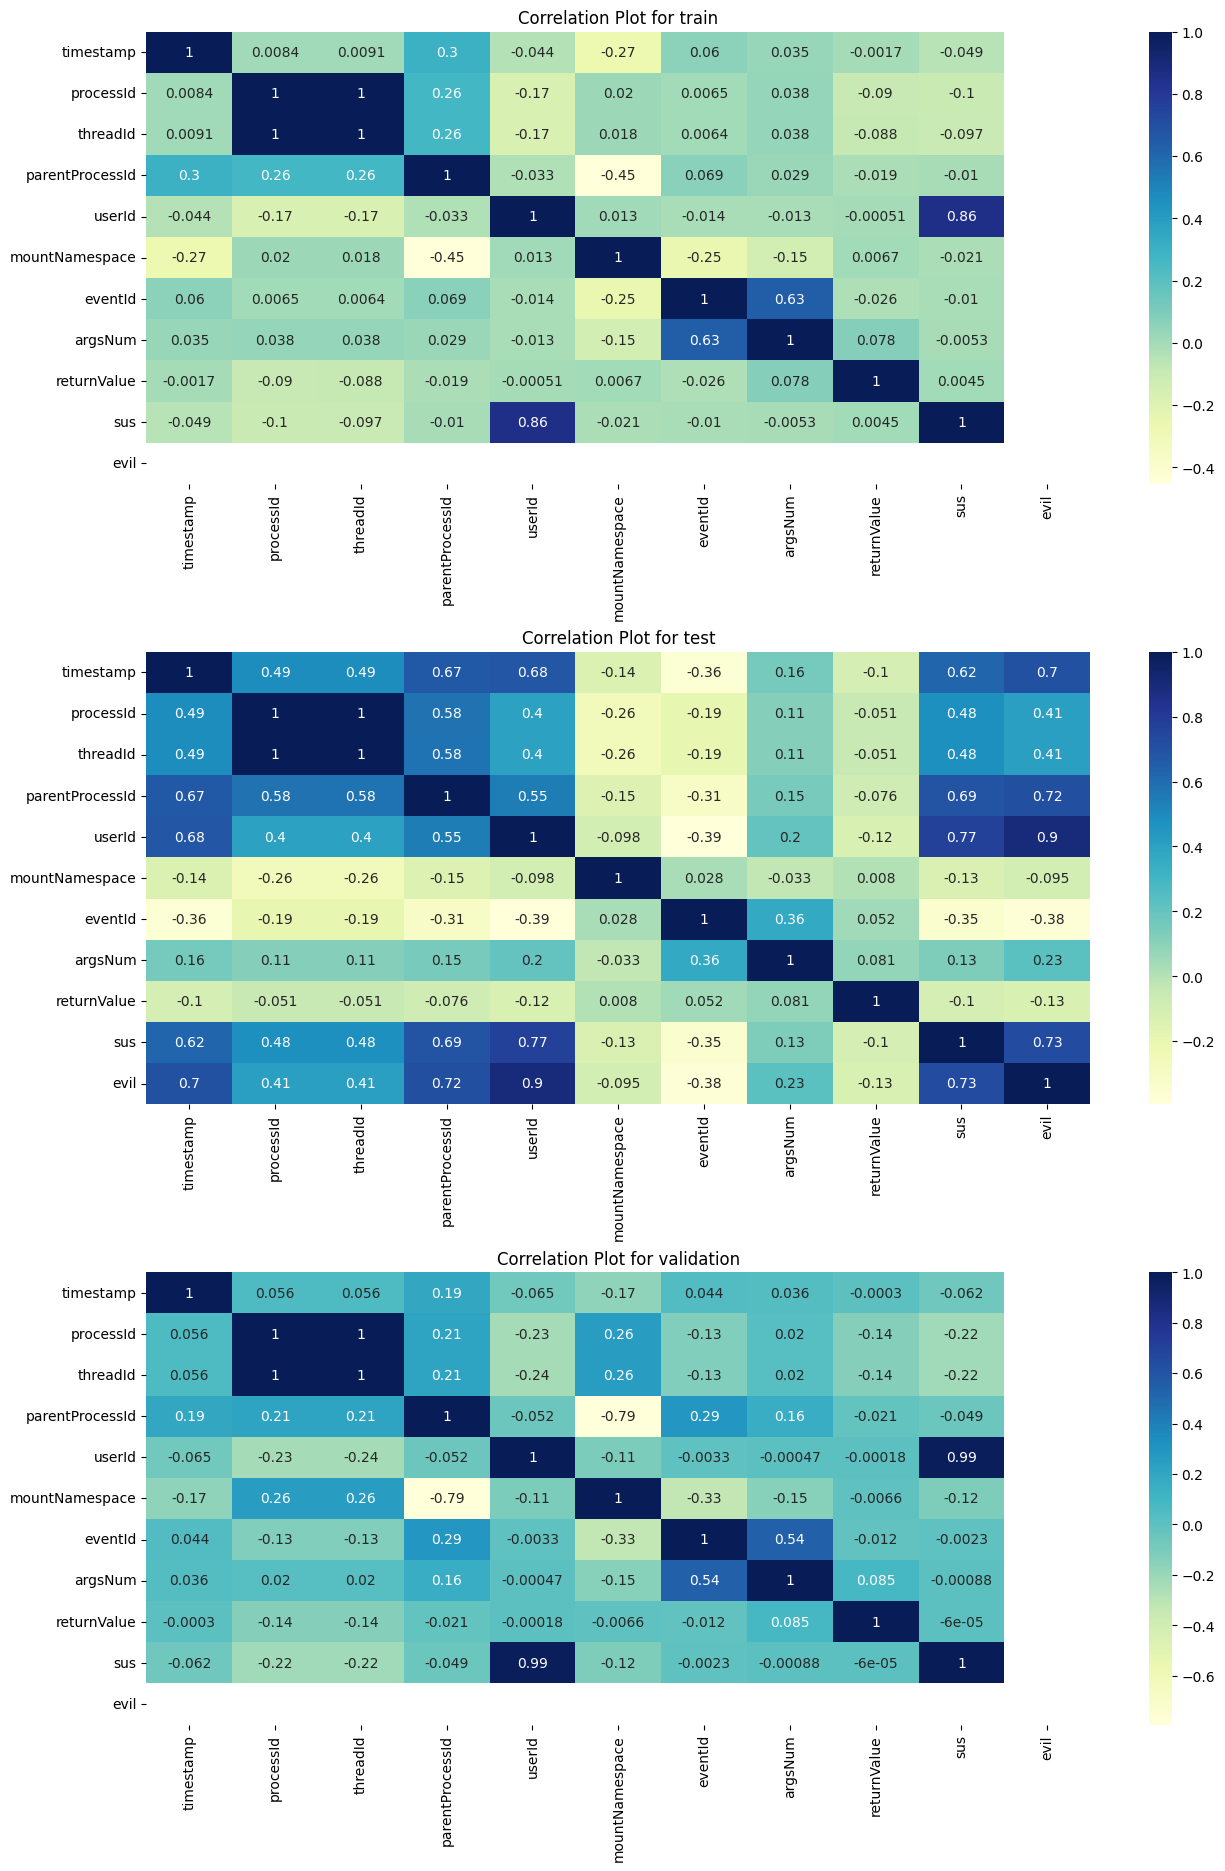

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,20))
fig.tight_layout(pad=10.0)
datasets = [train_df, test_df, validation_df]
dataset_names = ['train', 'test', 'validation']
axs = [ax1, ax2, ax3]

for dataset, name, ax in zip(datasets, dataset_names, axs):
    dataset_to_corr_heatmap(dataset, name, ax)

## Experimenting with ways to compare the datasets

### Entropy

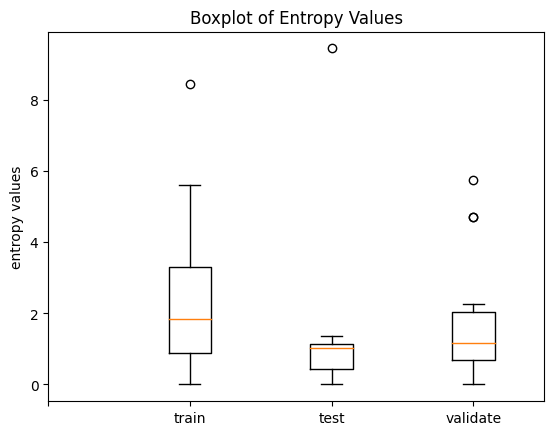

In [ ]:
datasets = [train_df, test_df, validation_df]

entropy_values = []
for dataset in datasets:
    dataset_entropy_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_entropy = stats.entropy(counts)
            dataset_entropy_values.append(col_entropy)

    entropy_values.append(dataset_entropy_values)

plt.boxplot(entropy_values)
plt.title('Boxplot of Entropy Values')
plt.ylabel("entropy values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

### Variation

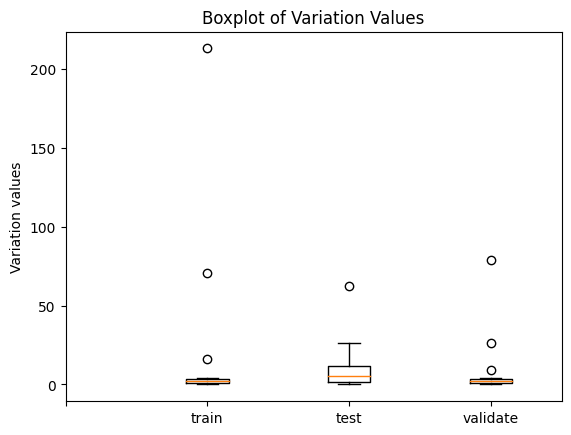

In [ ]:
datasets = [train_df, test_df, validation_df]

variation_values = []
for dataset in datasets:
    dataset_variation_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_variation = stats.variation(counts)
            dataset_variation_values.append(col_variation)

    variation_values.append(dataset_variation_values)

plt.boxplot(variation_values)
plt.title('Boxplot of Variation Values')
plt.ylabel("Variation values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

## Exploring the Non-Numeric Cols

Let's use the `train_df` for this exploration

From looking at the annex of the paper related to this dataset, the `eventName` columns maps directly to the `eventId` column as shown in the cell below, becuase of this, it'll be ignored in the analysis. (Look at line 2 (idx 1) and line 8 (idx 7))

In [ ]:
train_df.loc[:, ['eventId', 'eventName', 'processName', 'hostName', 'args']].head(10)

,eventId,eventName,processName,hostName,args
0,157,prctl,close,ip-10-100-1-120,"[{'name': 'option', 'type': 'int', 'value': 'P..."
1,3,close,close,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 19}]"
2,1010,sched_process_exit,close,ip-10-100-1-120,[]
3,21,access,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
4,1005,security_file_open,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
5,257,openat,sh,ip-10-100-1-120,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."
6,5,fstat,sh,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 3}, {'..."
7,3,close,sh,ip-10-100-1-120,"[{'name': 'fd', 'type': 'int', 'value': 3}]"
8,1005,security_file_open,sh,ip-10-100-1-120,"[{'name': 'pathname', 'type': 'const char*', '..."
9,257,openat,sh,ip-10-100-1-120,"[{'name': 'dirfd', 'type': 'int', 'value': -10..."


## Check Unique Values for all three of the fields above

In [ ]:
def column_uniques(df, col):
    print(f'{col} - Uniques:\n\n{df[col].unique()} \n\nNo. Uniques: {df[col].nunique()}')

In [ ]:
column_uniques(train_df, 'processName')

processName - Uniques:

['close' 'sh' 'run-parts' 'atd' 'systemd-logind' 'systemd'
 'systemd-journal' 'dbus-daemon' '(time-dir)' 'systemd-user-ru' 'docker'
 'systemd-resolve' 'dockerd' 'containerd-shim' 'amazon-ssm-agen' 'ps'
 'cron' 'snapd' 'systemd-network' 'journal-offline' 'kworker/dying'
 'ssm-agent-worke' 'packagekitd' 'gdbus' 'gmain' '(tmpfiles)'
 'systemd-tmpfile' 'kworker/u30:1' 'poweroff' '(sd-sync)' 'kworker/u30:0'
 'kworker/u30:2' 'systemd-timesyn' 'systemd-udevd' '(sd-pam)' 'sshd'] 

No. Uniques: 36


This column contains the process names and could be processed further to create binary features. For example, a feature called `amazon or not` could be one or `systemd or not`. Something to explore later.

In [ ]:
column_uniques(train_df, 'hostName')

hostName - Uniques:

['ip-10-100-1-120' 'ip-10-100-1-173' 'ip-10-100-1-28' 'ip-10-100-1-34'
 'ip-10-100-1-55' 'ip-10-100-1-57' 'ip-10-100-1-79' 'ubuntu'] 

No. Uniques: 8


This columns looks fairly useless for model training. As the dataset authors mention in the paper, this field is probs only useful for linking activity together in the dataset.

In [ ]:
column_uniques(train_df, 'args')

args - Uniques:

["[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NAME'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94819493392601}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140662171848350}, {'name': 'arg5', 'type': 'unsigned long', 'value': 140662156379904}]"
 "[{'name': 'fd', 'type': 'int', 'value': 19}]" '[]' ...
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_SECCOMP'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 2}, {'name': 'arg3', 'type': 'unsigned long', 'value': 94764243566176}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'unsigned long', 'value': 0}]"
 "[{'name': 'option', 'type': 'int', 'value': 'PR_SET_NO_NEW_PRIVS'}, {'name': 'arg2', 'type': 'unsigned long', 'value': 1}, {'name': 'arg3', 'type': 'unsigned long', 'value': 0}, {'name': 'arg4', 'type': 'unsigned long', 'value': 140537881935518}, {'name': 'arg5', 'type': 'u

# Process Training Dataset

From reading the paper's annex and the code from the linked github, there are several easy processing steps that we can take. The below code has been directly copied from the github repo.

In [ ]:
# resource: https://github.com/jinxmirror13/BETH_Dataset_Analysis
train_df["processId"] = train_df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["parentProcessId"] = train_df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_df["userId"] = train_df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_df["mountNamespace"] = train_df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_df["eventId"] = train_df["eventId"]  # Keep eventId values (requires knowing max value)
train_df["returnValue"] = train_df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error

In [ ]:
train_df.head(5)

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,1,7337,0,0,1,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,1,7337,0,0,1,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,1,7337,0,0,1,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,1,7347,1,0,0,sh,ip-10-100-1-120,21,access,[],2,2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,1,7347,1,0,0,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [ ]:
train = train_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
train_labels = train_df['sus']

In [ ]:
train.head(5) # list first five data of train dataset

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,1,0,0,1,157,5,0
1,1,0,0,1,3,1,0
2,1,0,0,1,1010,0,0
3,1,1,0,0,21,2,2
4,1,1,0,0,1005,4,0


In [ ]:
train_labels

0         1
1         1
2         1
3         1
4         1
         ..
763139    0
763140    0
763141    0
763142    0
763143    0
Name: sus, Length: 763144, dtype: int64

In [ ]:
assert len(train_labels) == train.shape[0] # Make sure the dataset's shape can fit the label numbers

1. 條件篩選數據：根據參數dataset的值，選擇特定子集的數據。

2. 標籤編碼：對部分特徵列進行標籤編碼，將類別值轉換為數字表示。

3. 特徵縮放：對一部分數值型特徵進行MinMax縮放，將特徵值壓縮到0和1之間。

4. 最終，該函數返回經過前處理後的特徵和對應的標籤，以便用於機器學習模型的訓練或其他分析任務中。

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def prepare_dataset(df: pd.DataFrame, dataset=False) -> pd.DataFrame:

    if dataset == True:
      df = df[df['sus'] == 0]
    le = preprocessing.LabelEncoder()
    df["processId"] = df["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["parentProcessId"] = df["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
    df["userId"] = df["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
    df["mountNamespace"] = df["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
    df["eventId"] = le.fit_transform(df['eventId'])  # Keep eventId values (requires knowing max value)
    df["returnValue"] = df["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error


    #normalize data using MinMaxScaler
    features = df[["eventId", "argsNum"]]
    normalized_features = scaler.fit_transform(features)
    df["eventId"] = normalized_features[:, 0]
    df["argsNum"] = normalized_features[:, 1]

    features = df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]
    labels = df['sus']

    return features, labels

In [ ]:
train_no_args_feats, train_no_args_labels = prepare_dataset(train_df)

In [ ]:
new_train_df = train_df.sample(frac=0.2, random_state=42)

In [ ]:
train_df_feats, train_df_labels = prepare_dataset(new_train_df, True)
test_df_feats, test_df_labels = prepare_dataset(test_df)
val_df_feats, val_df_labels = prepare_dataset(validation_df)

In [ ]:
train_df_feats

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
116781,0,0,0,1,0.000000,0.2,0
226098,0,0,0,1,0.032258,0.4,0
550118,0,0,0,1,0.000000,0.2,0
642464,0,0,0,1,0.000000,0.2,0
146759,0,0,0,1,0.935484,0.8,0
...,...,...,...,...,...,...,...
446304,0,0,0,1,0.935484,0.8,0
341988,0,0,0,1,0.741935,0.8,1
483428,0,0,0,1,0.741935,0.8,1
394187,0,0,0,1,0.000000,0.2,0


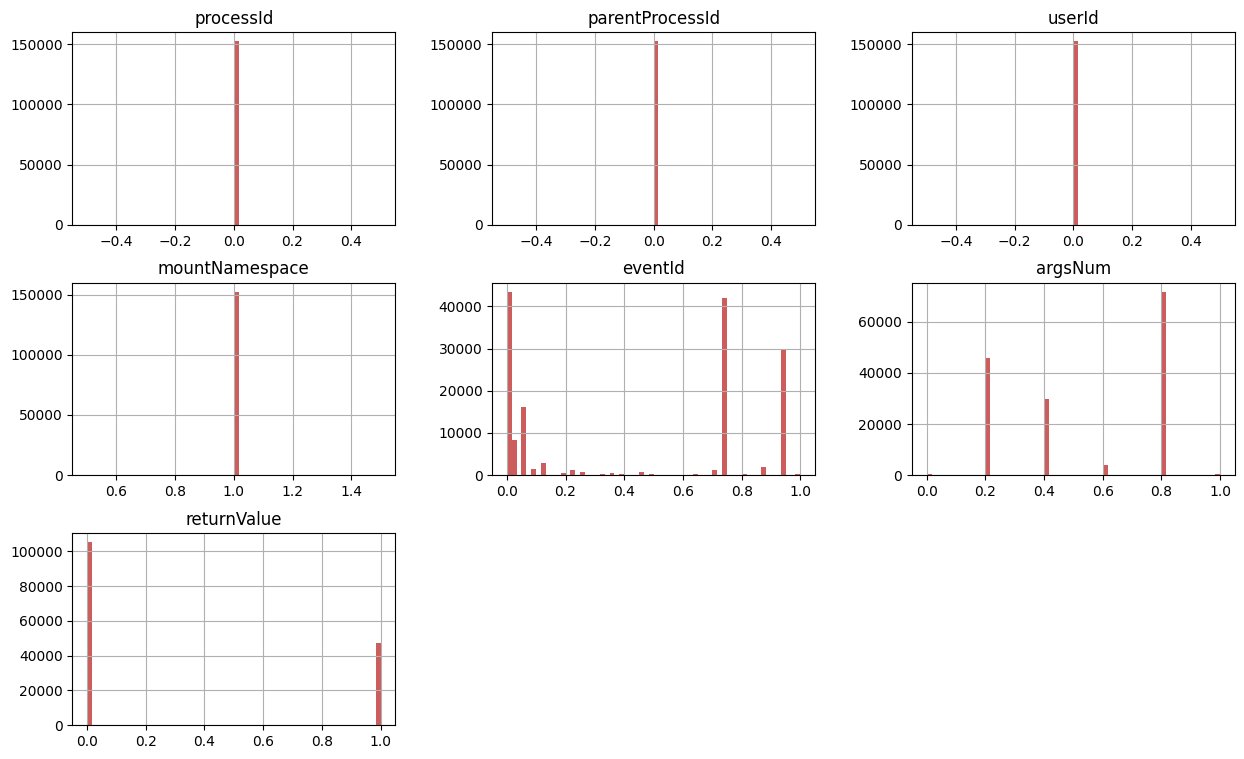

In [ ]:
#查看資料集的分佈
train_df_feats.hist(bins=60, figsize=(15,9),color='IndianRed')
plt.show()

#  Evaluation of Model



> 異常偵測模型在評估其性能時，僅使用 **準確度（accuracy）**作為評估指標可能是不足夠的，原因如下：
1. 類別不平衡問題：在異常偵測中，正常樣本通常遠多於異常樣本。這導致模型偏向於將大多數樣本歸為正常，而忽略了異常樣本。即使模型在預測正常樣本上具有高準確度，也不能確保其對異常樣本的偵測能力。
2. 成本敏感性：在異常偵測中，誤報（將正常樣本誤分類為異常）和漏報（未能檢測到異常樣本）可能具有不同的成本後果。準確度無法區分這兩種錯誤，無法提供關於不同錯誤類型的信息，這在實際應用中可能非常重要。

因此，除了準確度之外，異常偵測模型通常還需要使用其他評估指標，如精確度（precision）、召回率（recall）、F1分數（F1-score）和AUC-ROC曲線（Area Under the ROC Curve）等，來綜合評估模型的性能。這些指標可以提供更全面和平衡的評估，並考慮到異常偵測中的特殊需求。




In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
def metric_printer(y_true, y_pred):

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1-Score: {f1:.3f}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'ROC AUC: {roc_auc:.3f}')
    print('Confusion Matrix:')
    print(cm)

## LocalOutlierFactor

Local Outlier Factor（LOF）是一種用於異常偵測的算法。它基於密度的方法，用於評估給定數據點的異常程度。LOF算法通過比較每個數據點周圍鄰居的密度，來確定該數據點是否異常。

LOF算法的基本思想是，異常數據點的鄰域密度應該與其周圍正常數據點的鄰域密度相比，較低。換句話說，異常數據點的鄰域密度應該相對較小，而正常數據點的鄰域密度應該相對較大。

### 為什麼選擇
1. 基於局部密度：LOF算法基於局部密度的概念，評估每個數據點的異常程度。它考慮了數據點周圍鄰域的密度，而不僅僅基於全局或平均密度。這使得LOF能夠捕捉到具有不同密度區域的異常，對於不同區域之間的密度變化敏感。

2. 對異常樣本敏感：LOF算法對於異常樣本的敏感度相對較高。由於異常樣本在其周圍的鄰域密度相對較低，LOF算法能夠檢測到這種差異，將異常樣本與正常樣本區分開來。

3. 考慮局部上下文：LOF算法通過比較數據點的局部密度與其鄰域數據點的密度，從局部上下文的角度來評估異常程度。這有助於捕捉到在整體數據分布中可能被忽略的異常模式。

4. 不依賴全局閾值：LOF算法不需要依賴全局閾值或事先定義的參數來進行異常偵測。相反，它通過比較數據點與其鄰域的關係來計算局部異常因子，從而自適應地識別異常樣本。

5. 應用靈活性：LOF算法可以應用於不同類型的數據，包括數值型、類別型和混合型數據。這使得它在各種領域的異常偵測應用中具有廣泛的適用性。

In [ ]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Fit the LOF model
lof = LocalOutlierFactor(contamination=0.1, novelty=True).fit(train_df_feats)

In [ ]:
y_pred_lof = lof.predict(val_df_feats)
y_pred_lof = np.where(y_pred_lof==-1, 1, 0)

metric_printer(val_df_labels, y_pred_lof)

Precision: 0.004
Recall: 1.000
F1-Score: 0.008
Accuracy: 0.004
ROC AUC: 0.500
Confusion Matrix:
[[     0 188181]
 [     0    786]]


In [ ]:
y_pred_lof = lof.predict(test_df_feats)
y_pred_lof = np.where(y_pred_lof==-1, 1, 0)

metric_printer(test_df_labels, y_pred_lof)

Precision: 0.907
Recall: 1.000
F1-Score: 0.951
Accuracy: 0.907
ROC AUC: 0.500
Confusion Matrix:
[[     0  17508]
 [     0 171459]]


## Isolation Forest
- 選擇原因：
1. Isolation Forest是一種`常見`的異常檢測方法之一。它是一種基於樹結構的異常檢測算法，通常用於檢測數據中的異常或不正常樣本。
2. 大型數據集的可擴展性較好，不受特徵維度的影響，並且可以有效處理多維數據。它在檢測數據集中的異常樣本方面表現良好，並且通常被應用於各種領域，如網絡安全、金融詐騙檢測、監控系統等。

##### 結論
總結而言，使用Isolation Forest方法的模型在`測試數據集`上表現較好，具有較高的精確率、召回率、F1分數和準確率。然而，在`驗證數據集`上，模型的性能相對較差，精確率、召回率和F1分數較低。建議對模型進行進一步的調優和優化，可能需要考慮調整模型的參數或嘗試其他的異常檢測方法以提高其性能和穩定性。

In [ ]:
isf = IsolationForest(contamination=0.1, random_state=0).fit(train_df_feats)

In [ ]:
y_pred_if_val = isf.predict(val_df_feats)
y_pred_if_val = np.where(y_pred_if_val==-1, 1, 0)
metric_printer(val_df_labels, y_pred_if_val)

Precision: 0.006
Recall: 0.658
F1-Score: 0.013
Accuracy: 0.572
ROC AUC: 0.615
Confusion Matrix:
[[107508  80673]
 [   269    517]]


In [ ]:
y_pred_if_test = isf.predict(test_df_feats)
y_pred_if_test = np.where(y_pred_if_test==-1, 1, 0)
metric_printer(test_df_labels, y_pred_if_test)

Precision: 0.985
Recall: 0.880
F1-Score: 0.930
Accuracy: 0.879
ROC AUC: 0.874
Confusion Matrix:
[[ 15180   2328]
 [ 20516 150943]]


## One Class Support Vector Machine
- 選擇原因：由於數據集的規模較大，使用了隨機梯度下降（SGD）版本的單類支持向量機（One Class SVM）。

##### 結論
總結而言，使用Isolation Forest方法的模型在`測試數據集`上表現較好，具有較高的精確率、召回率、F1分數和準確率。然而，在`驗證數據集`上，模型的性能相對較差，精確率、召回率和F1分數較低。

In [ ]:
train_non_outliers = train_df_feats[train_df_labels==0]
ocsvm = linear_model.SGDOneClassSVM(random_state=0).fit(train_df_feats)

In [ ]:
y_preds_ocsvm_val = ocsvm.predict(val_df_feats)
y_preds_ocsvm_val = np.where(y_preds_ocsvm_val==-1, 1, 0)
metric_printer(val_df_labels, y_preds_ocsvm_val)

Precision: 0.006
Recall: 1.000
F1-Score: 0.012
Accuracy: 0.292
ROC AUC: 0.644
Confusion Matrix:
[[ 54341 133840]
 [     0    786]]


In [ ]:
y_preds_ocsvm_test = ocsvm.predict(test_df_feats)
y_preds_ocsvm_test = np.where(y_preds_ocsvm_test==-1, 1, 0)
metric_printer(test_df_labels, y_preds_ocsvm_test)

Precision: 0.908
Recall: 1.000
F1-Score: 0.952
Accuracy: 0.908
ROC AUC: 0.504
Confusion Matrix:
[[   137  17371]
 [     0 171459]]


In [ ]:
train_non_outliers

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
116781,0,0,0,1,0.000000,0.2,0
226098,0,0,0,1,0.032258,0.4,0
550118,0,0,0,1,0.000000,0.2,0
642464,0,0,0,1,0.000000,0.2,0
146759,0,0,0,1,0.935484,0.8,0
...,...,...,...,...,...,...,...
446304,0,0,0,1,0.935484,0.8,0
341988,0,0,0,1,0.741935,0.8,1
483428,0,0,0,1,0.741935,0.8,1
394187,0,0,0,1,0.000000,0.2,0


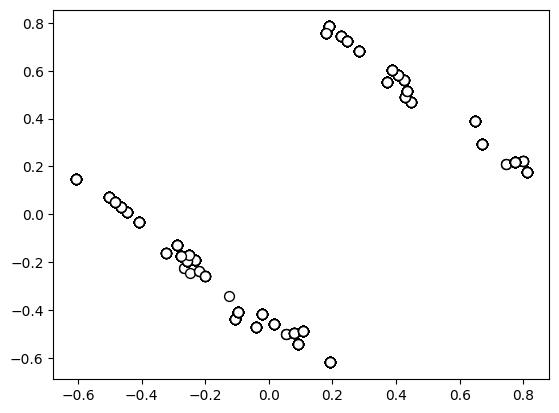

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_df_feats)

train_df_feats_pca = pca.transform(train_df_feats)

x_min, x_max = train_df_feats_pca[:, 0].min() - 1, train_df_feats_pca[:, 0].max() + 1
y_min, y_max = train_df_feats_pca[:, 1].min() - 1, train_df_feats_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))


Z = ocsvm.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.scatter(train_df_feats_pca[:, 0], train_df_feats_pca[:, 1], c='white', edgecolors='black', s=50)


## Gaussian Mixture Model
- 選擇原因：具有擬合多模態分佈、柔性的分佈建模和異常度量解釋性等優勢，因此在異常檢測中被廣泛選擇和應用。

##### 結論
- 綜合評估結果，精確率、召回率、F1分數和準確率等等顯示無論是在驗證數據集還是測試數據集上，模型的性能不太理想，。模型的準確率很低，且在正類樣本的檢測方面表現不佳。



In [ ]:
from sklearn.mixture import GaussianMixture

# Fit the GMM model
gmm = GaussianMixture(n_components=2).fit(train_df_feats)  # Adjust the number of components as needed

In [ ]:
# Predict anomaly scores
anomaly_scores = -gmm.score_samples(val_df_feats)

# Define a threshold for classifying anomalies
threshold = np.mean(anomaly_scores) + np.std(anomaly_scores)  # Adjust the threshold as needed

# Classify anomalies based on the threshold
y_pred_gmm = (anomaly_scores > threshold).astype(int)
metric_printer(val_df_labels, y_pred_gmm)

Precision: 0.017
Recall: 0.989
F1-Score: 0.033
Accuracy: 0.762
ROC AUC: 0.875
Confusion Matrix:
[[143300  44881]
 [     9    777]]


In [ ]:
y_pred_gmm = gmm.predict(test_df_feats)

# Evaluate the model
metric_printer(test_df_labels, y_pred_gmm)

Precision: 0.582
Recall: 0.103
F1-Score: 0.175
Accuracy: 0.119
ROC AUC: 0.190
Confusion Matrix:
[[  4850  12658]
 [153843  17616]]


## PCA
- 選擇原因：在異常檢測中具有維度降低、特徵提取、數據可視化和無監督等優勢，因此被廣泛選擇和應用於異常檢測場景中。

##### 結論
使用 PCA 方法的模型無論在`測試數據集`或者`驗證數據集`表現都低於平均值。

In [ ]:
from sklearn.decomposition import PCA
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca.fit(train_df_feats)
reduced_train_data = pca.transform(train_df_feats)
# Apply PCA on the validation data
reduced_val_data = pca.transform(val_df_feats)

# Calculate the reconstruction error for each validation data point
reconstructed_val_data = pca.inverse_transform(reduced_val_data)
reconstruction_error = np.sum(np.square(val_df_feats - reconstructed_val_data), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 90)

# Predict anomalies based on the reconstruction error
y_pred_pca = np.where(reconstruction_error > threshold, 1, 0)

# Print evaluation metrics
metric_printer(val_df_labels, y_pred_pca)

Precision: 0.045
Recall: 0.874
F1-Score: 0.085
Accuracy: 0.922
ROC AUC: 0.898
Confusion Matrix:
[[173528  14653]
 [    99    687]]


In [ ]:
# Apply PCA on the validation data
reduced_test_data = pca.transform(test_df_feats)

# Calculate the reconstruction error for each validation data point
reconstructed_test_data = pca.inverse_transform(reduced_test_data)
reconstruction_error = np.sum(np.square(test_df_feats - reconstructed_test_data), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 90)

# Predict anomalies based on the reconstruction error
y_pred_pca = np.where(reconstruction_error > threshold, 1, 0)

# Print evaluation metrics
metric_printer(test_df_labels, y_pred_pca)

Precision: 1.000
Recall: 0.055
F1-Score: 0.105
Accuracy: 0.143
ROC AUC: 0.528
Confusion Matrix:
[[ 17508      0]
 [161959   9500]]


## SVDD
- 選擇原因：SVDD 具有基於支持向量機的優勢、單類別模型的特點、彈性的邊界和解釋性等優點，因此在異常檢測中被廣泛選擇和應用。

In [ ]:
!pip install --upgrade pyod
from pyod.models.deep_svdd import DeepSVDD

# Train a SVDD model using the scaled training data
dsvdd = DeepSVDD(contamination=0.1, batch_size=128, epochs=10, random_state=42).fit(train_df_feats)

# Predict anomalies on the scaled validation data
y_pred_dsvdd = dsvdd.predict(val_df_feats)
y_pred_dsvdd = np.where(y_pred_dsvdd == 1, 0, 1)  # Invert the labels: 1 for anomaly, 0 for normal

# Print evaluation metrics
metric_printer(val_df_labels, y_pred_dsvdd)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184097 sha256=6f6f148cc0ec1a91101eca1c05a11f71671aa4c900ace127558fefece6b1ddca
  Stored in directory: /root/.cache/pip/wheels/83/55/6b/552e083cf5509c0afe808b76cf434f1be284d01a112623bd37
Successfully built pyod
4763/4763 [==============================] - 6s 1ms/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 64)                448       
                                                                 
 net_output (Dense)          (N

In [ ]:
# Predict anomalies on the scaled validation data
y_pred_dsvdd = dsvdd.predict(test_df_feats)
y_pred_dsvdd = np.where(y_pred_dsvdd == 1, 0, 1)  # Invert the labels: 1 for anomaly, 0 for normal

# Print evaluation metrics
metric_printer(test_df_labels, y_pred_dsvdd)

5906/5906 [==============================] - 18s 3ms/step
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
Accuracy: 0.093
ROC AUC: 0.500
Confusion Matrix:
[[ 17508      0]
 [171459      0]]


# Conclusion
在測試資料集上，`One Class Support Vector Machine（單類支持向量機）`方法表現最佳。該方法在精確率、召回率、F1分數和準確率方面表現良好，同時具有較高的ROC AUC值。

#### Discussion
1. 資料及不平衡

> 由於 train_df 的 dataset 裡面，sus 等於 0 的值為多數，幾乎是佔了 90 % 以上，反觀 test_df，sus 等於 1 的數據為多數，但 validation_df 的數據分佈是和 train_df 相似的，我們推測也許透過 train_df 所訓練之來的模型，對於 test_df 能夠有很好分辯的效果，因為幾乎都是不同於 train_df 的數據，所以能夠被很好的歸類為異常值，而 validation_df 因爲是類似分佈的狀況，因此很難分辨出異常值

